In [2]:
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt

from PIL import Image
from loess.loess_1d import loess_1d

In [77]:
from typing import Tuple
def d2tod1(r : int,
           c : int,
           ncols : int,
          )->int:
    
    return r * ncols + c

def d1tod2(x : int,
           ncols :int,
          )->Tuple[int]:
    
    r = x // ncols
    c = x % ncols
    
    return (r,c)

def d1tod2(x : Union[int,np.ndarray],
           ncols :int,
          )->Union[np.ndarray,Tuple[int]]:
    
    r = x // ncols
    c = x % ncols
    

    return (r,c)

In [78]:
xs = np.arange(5)
ys = d1tod2(xs,ncols = 3)

In [79]:
ys

(array([0, 0, 0, 1, 1]), array([0, 1, 2, 0, 1]))

In [6]:
cnt_pth = "/home/alma/w-projects/help/franzi/data/Liver_ST_AA_200909/CN73_C1_counts_genenames.tsv"
mask_pth ="/home/alma/w-projects/help/franzi/data/Liver_ST_AA_200909/img-mask-both.png"
img_pth = "/home/alma/w-projects/help/franzi/data/Liver_ST_AA_200909/img.jpg"
spt_pth = "/home/alma/w-projects/help/franzi/data/Liver_ST_AA_200909/spot_data-selection_ST_C073_Liver_C1.tsv"

In [3]:
cnt = pd.read_csv(cnt_pth,sep = '\t',header = 0, index_col = 0)
spt = pd.read_csv(spt_pth,sep = '\t',header = 0, index_col = None)
spt.index = pd.Index([str(x)+"x"+str(y) for x,y in zip(spt["x"].values,spt["y"].values)])

inter = spt.index.intersection(cnt.index)
cnt = cnt.loc[inter,:]
spt = spt.loc[inter,:]

obs = dict(_x = spt["x"].values,
           _y = spt["y"].values,
           x = spt["pixel_x"].values,
           y = spt["pixel_y"].values,
          )
obs = pd.DataFrame(obs, index = spt.index)

var = pd.DataFrame(dict(gene = cnt.columns),index = cnt.columns)

img = Image.open(img_pth)
img = np.asarray(img).astype(int)

In [9]:
mask = Image.open(mask_pth)
mask = np.asarray(mask).astype(int)

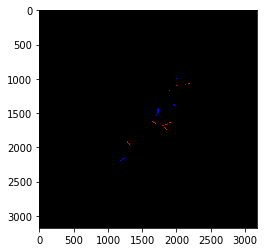

In [10]:
plt.imshow(mask)

In [35]:
n_types = 2
from sklearn.cluster import KMeans

mx,my,mc = mask.shape
cmask = mask.reshape(mx*my,mc)

km = KMeans(n_clusters = n_types + 1)
cidx = km.fit_predict(cmask)


In [43]:
background_idx = np.argmin(np.linalg.norm(km.cluster_centers_,axis =1))


In [90]:
cluster_list = dict(x = [],
                    y = [],
                    type = [])

for i in np.unique(cidx):
    if i != background_idx:
        pos = np.where(cidx == i)[0]
        _x,_y = d1tod2(pos,ncols=my)
        cluster_list["x"] += list(_x)
        cluster_list["y"] += list(_y)
        cluster_list["type"] += [i] * len(pos)


In [91]:
cluster_data = pd.DataFrame(cluster_list)

In [100]:
cluster_data.loc[cluster_data["type"]==1,["x","y"]]

,x,y
0,988,2019
1,988,2020
2,988,2021
3,988,2022
4,988,2023
...,...,...
5779,2255,1082
5780,2255,1083
5781,2256,1078
5782,2256,1079


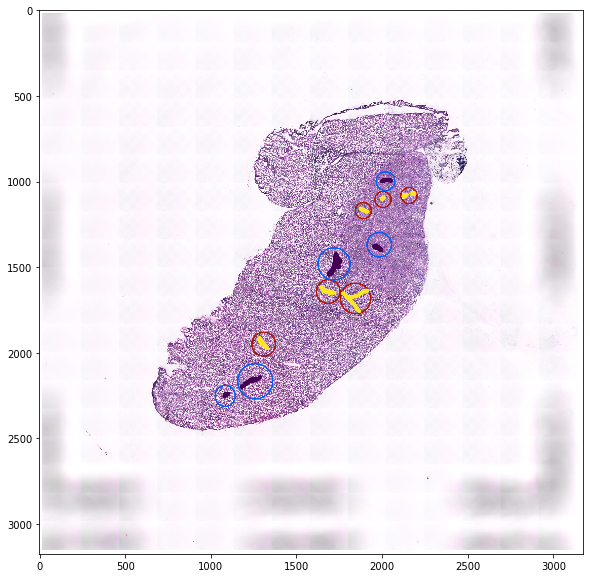

In [92]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(img)
ax.scatter(cluster_data["y"],cluster_data["x"],c = cluster_data["type"], s = 2)

In [101]:
cluster_data

,x,y,type
0,988,2019,1
1,988,2020,1
2,988,2021,1
3,988,2022,1
4,988,2023,1
...,...,...,...
10745,1975,1332,2
10746,1976,1329,2
10747,1976,1330,2
10748,1976,1331,2


In [115]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist


crd = cluster_data[["x","y"]].values
dist = cdist(crd,crd)
dist[dist == 0] = dist.max()
eps = np.quantile(dist,0.05)

segs = np.zeros(cluster_data.shape[0])

for k,ii in enumerate(np.unique(cluster_data["type"])):
    pos = cluster_data["type"] == ii
    
    crd = cluster_data[["x","y"]].values[pos,:]
    dist = cdist(crd,crd)
    dist[dist == 0] = dist.max()
    eps = np.quantile(dist,0.05)
    
    seg = DBSCAN(eps).fit_predict(crd)
    if k > 0:
        mx = segs.max()
        mn = seg.min()
        diff = (mx + 1) - mn
        segs[pos] = seg + diff
    else:
        segs[pos] = seg
        
    
    

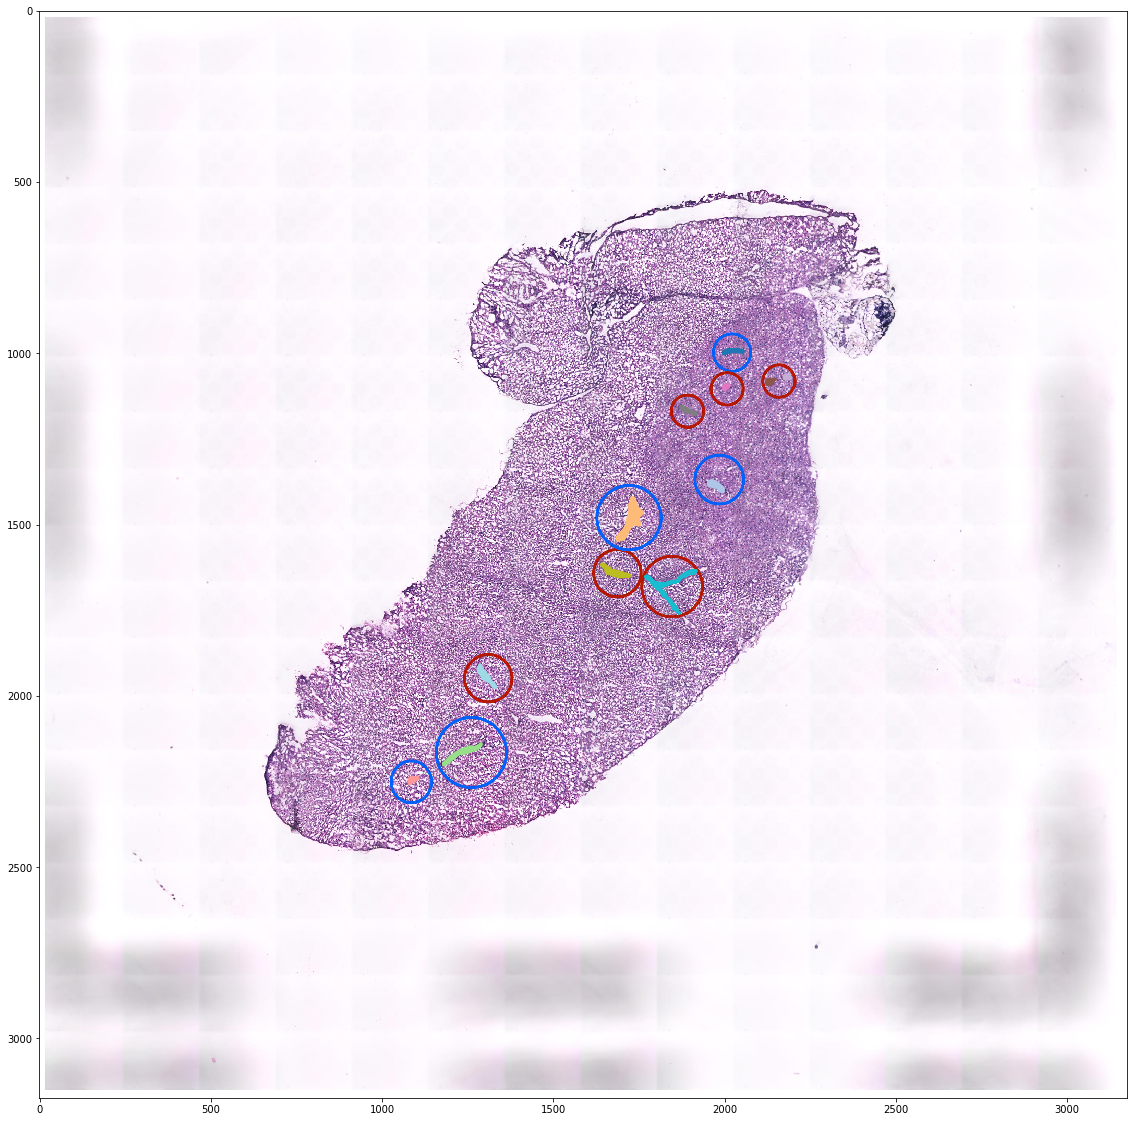

In [117]:
fig,ax = plt.subplots(1,1,figsize = (20,20))
ax.imshow(img)
ax.scatter(cluster_data["y"],
           cluster_data["x"],c = segs, s = 2, cmap = plt.cm.tab20)